In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tire-texture-image-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1731575%2F2830785%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241011%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241011T185146Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D98498eff2d3d19baaf0dd09819295f4c8dfc82c6e574bcf20a14549a149d6350c6f65e7ef074cab5876c66da2cf4c2aca60059414289af9453af4ddfa51a01bcdd69cc7c4bcdd71bb48c17d10f23985646959871383753576e12b2a9e6baa76227fc4c9d0bbd04b42e4b96bfd677b3848b09d50aad06e086fc345d243eddbea9328a94031e13a664badf4d88359189c1f31fd4b1ffa7e4f2b06eba50e82ed7ba2169a113f5b13e4eea39e38b97bd875b0544b45cf25f5d9658c5cdc4d647273116eee484188e9d5dc8d3c6c8c920a7ade5934a674161673d7d8bb58ea0f61f2d694f85806760cd5c7cea1f35e4b661aeb5749bc5bcb249f64a4f8ff80e1521ad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 741994332 bytes downloaded
Downloaded and uncompressed: tire-texture-image-recognition
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#NN Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

#Evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
train_generator = ImageDataGenerator(
    rotation_range = 360,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    zoom_range = 0.05,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.75, 1.25],
    rescale = 1./255,
    validation_split = 0.2
)

test_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
IMAGE_DIR = "../input/tire-texture-image-recognition/Tire Textures/"

IMAGE_SIZE = (379, 379)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"normal": 0, "cracked": 1},
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "training_data",subset = "training", shuffle = True, **gen_args)
validation_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "training_data",
                                        subset = "validation", shuffle = True, **gen_args)


Found 563 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [ ]:

# Cek apakah direktori ada
if os.path.exists(IMAGE_DIR):
    print("Jalur direktori ditemukan:", IMAGE_DIR)
else:
    print("Jalur direktori tidak ditemukan:", IMAGE_DIR)


Jalur direktori ditemukan: ../input/tire-texture-image-recognition/Tire Textures/


# Image Visualitation

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "testing_data",
                                                  shuffle = False,
                                                  **gen_args)

Found 325 images belonging to 2 classes.


In [ ]:
mapping_class = {0: "normal", 1: "cracked"}
mapping_class

{0: 'normal', 1: 'cracked'}

In [ ]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()

    return images

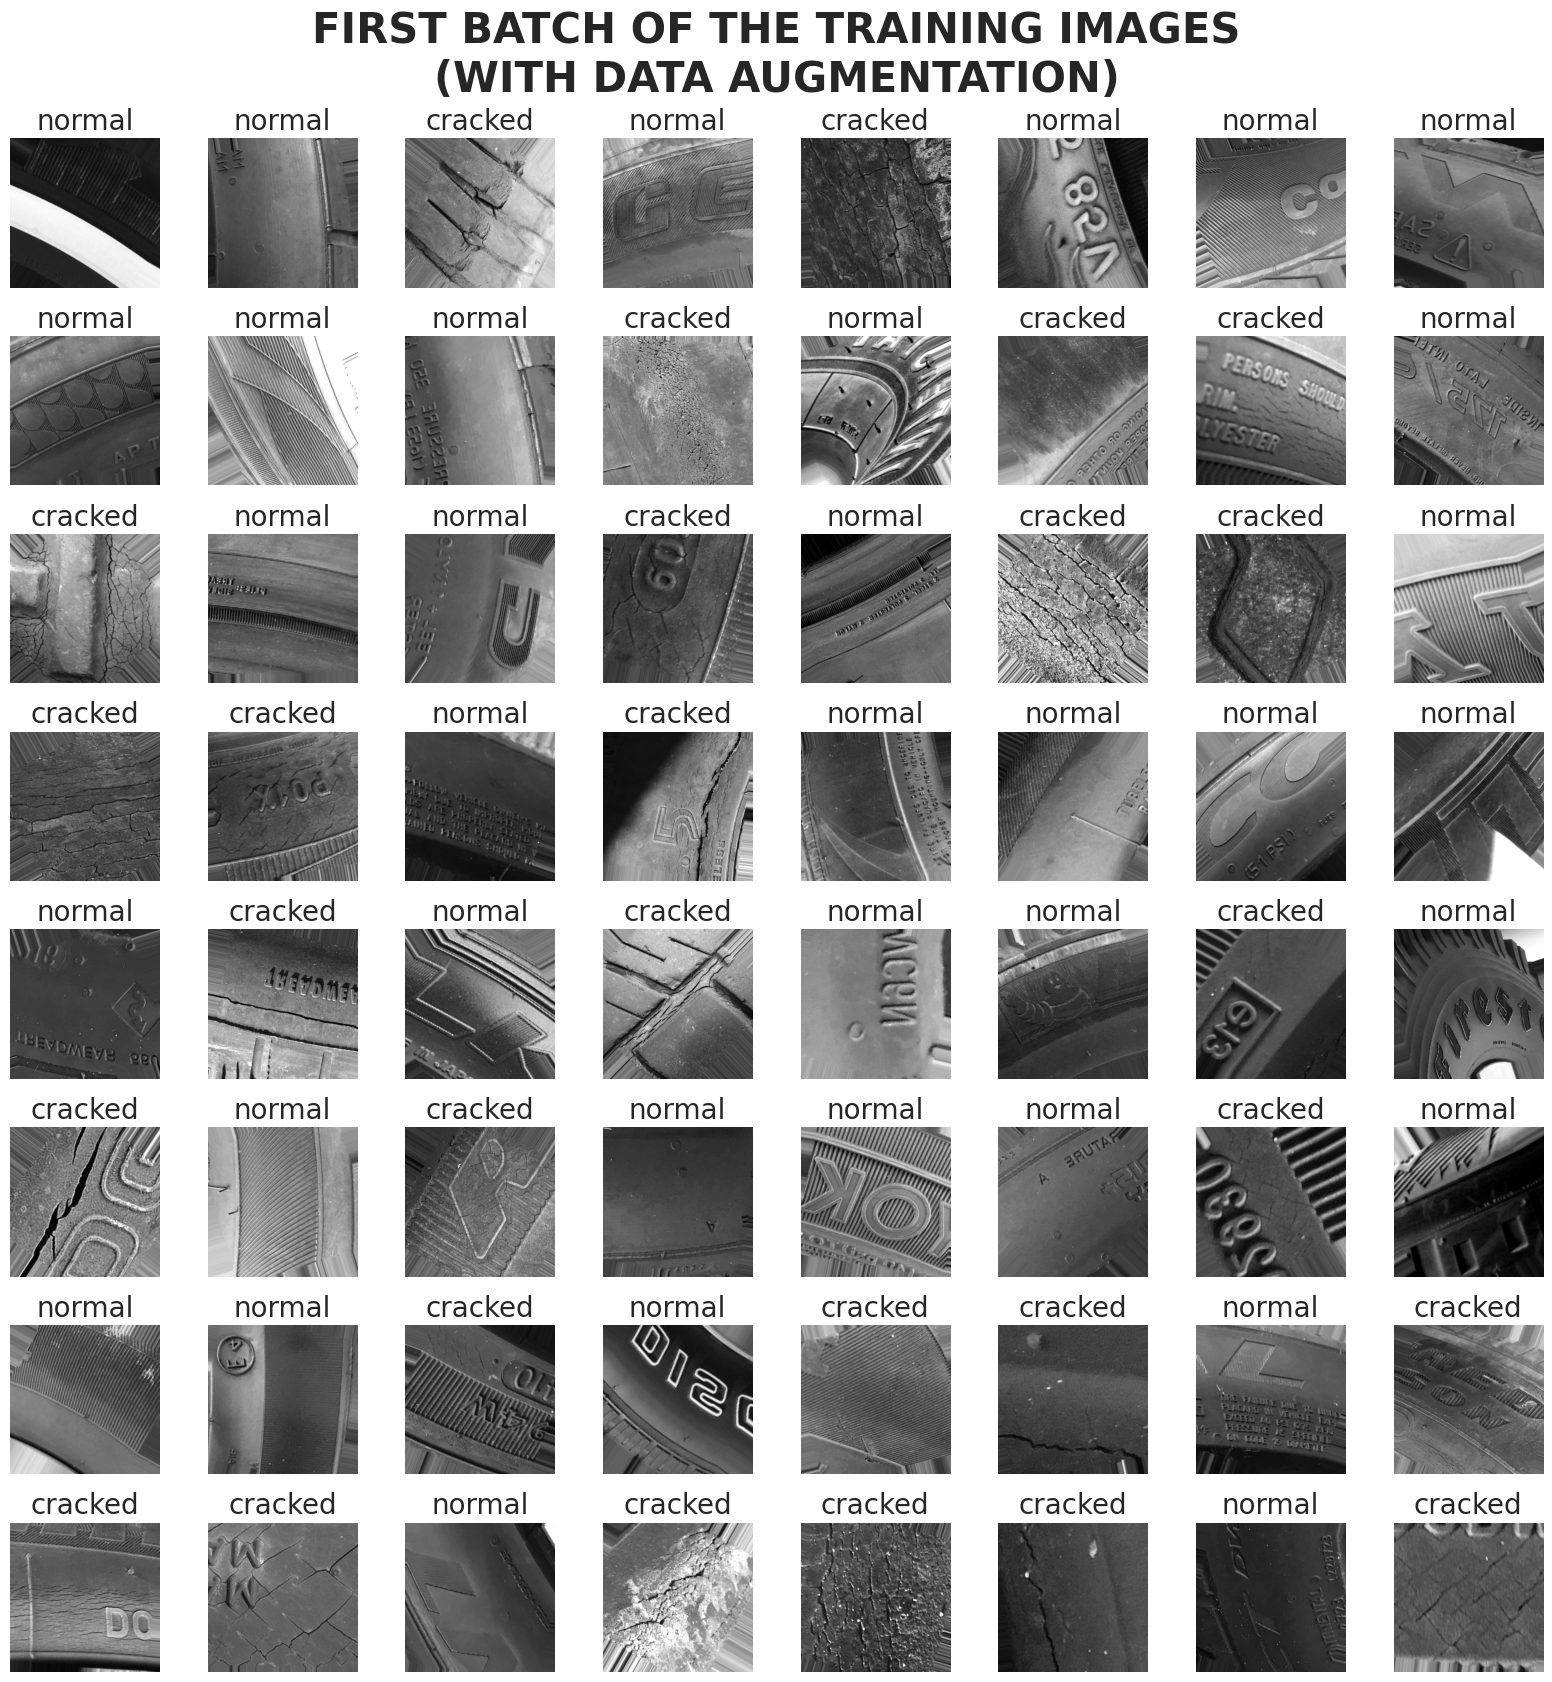

In [ ]:
train_images = visualizeImageBatch(train_dataset,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

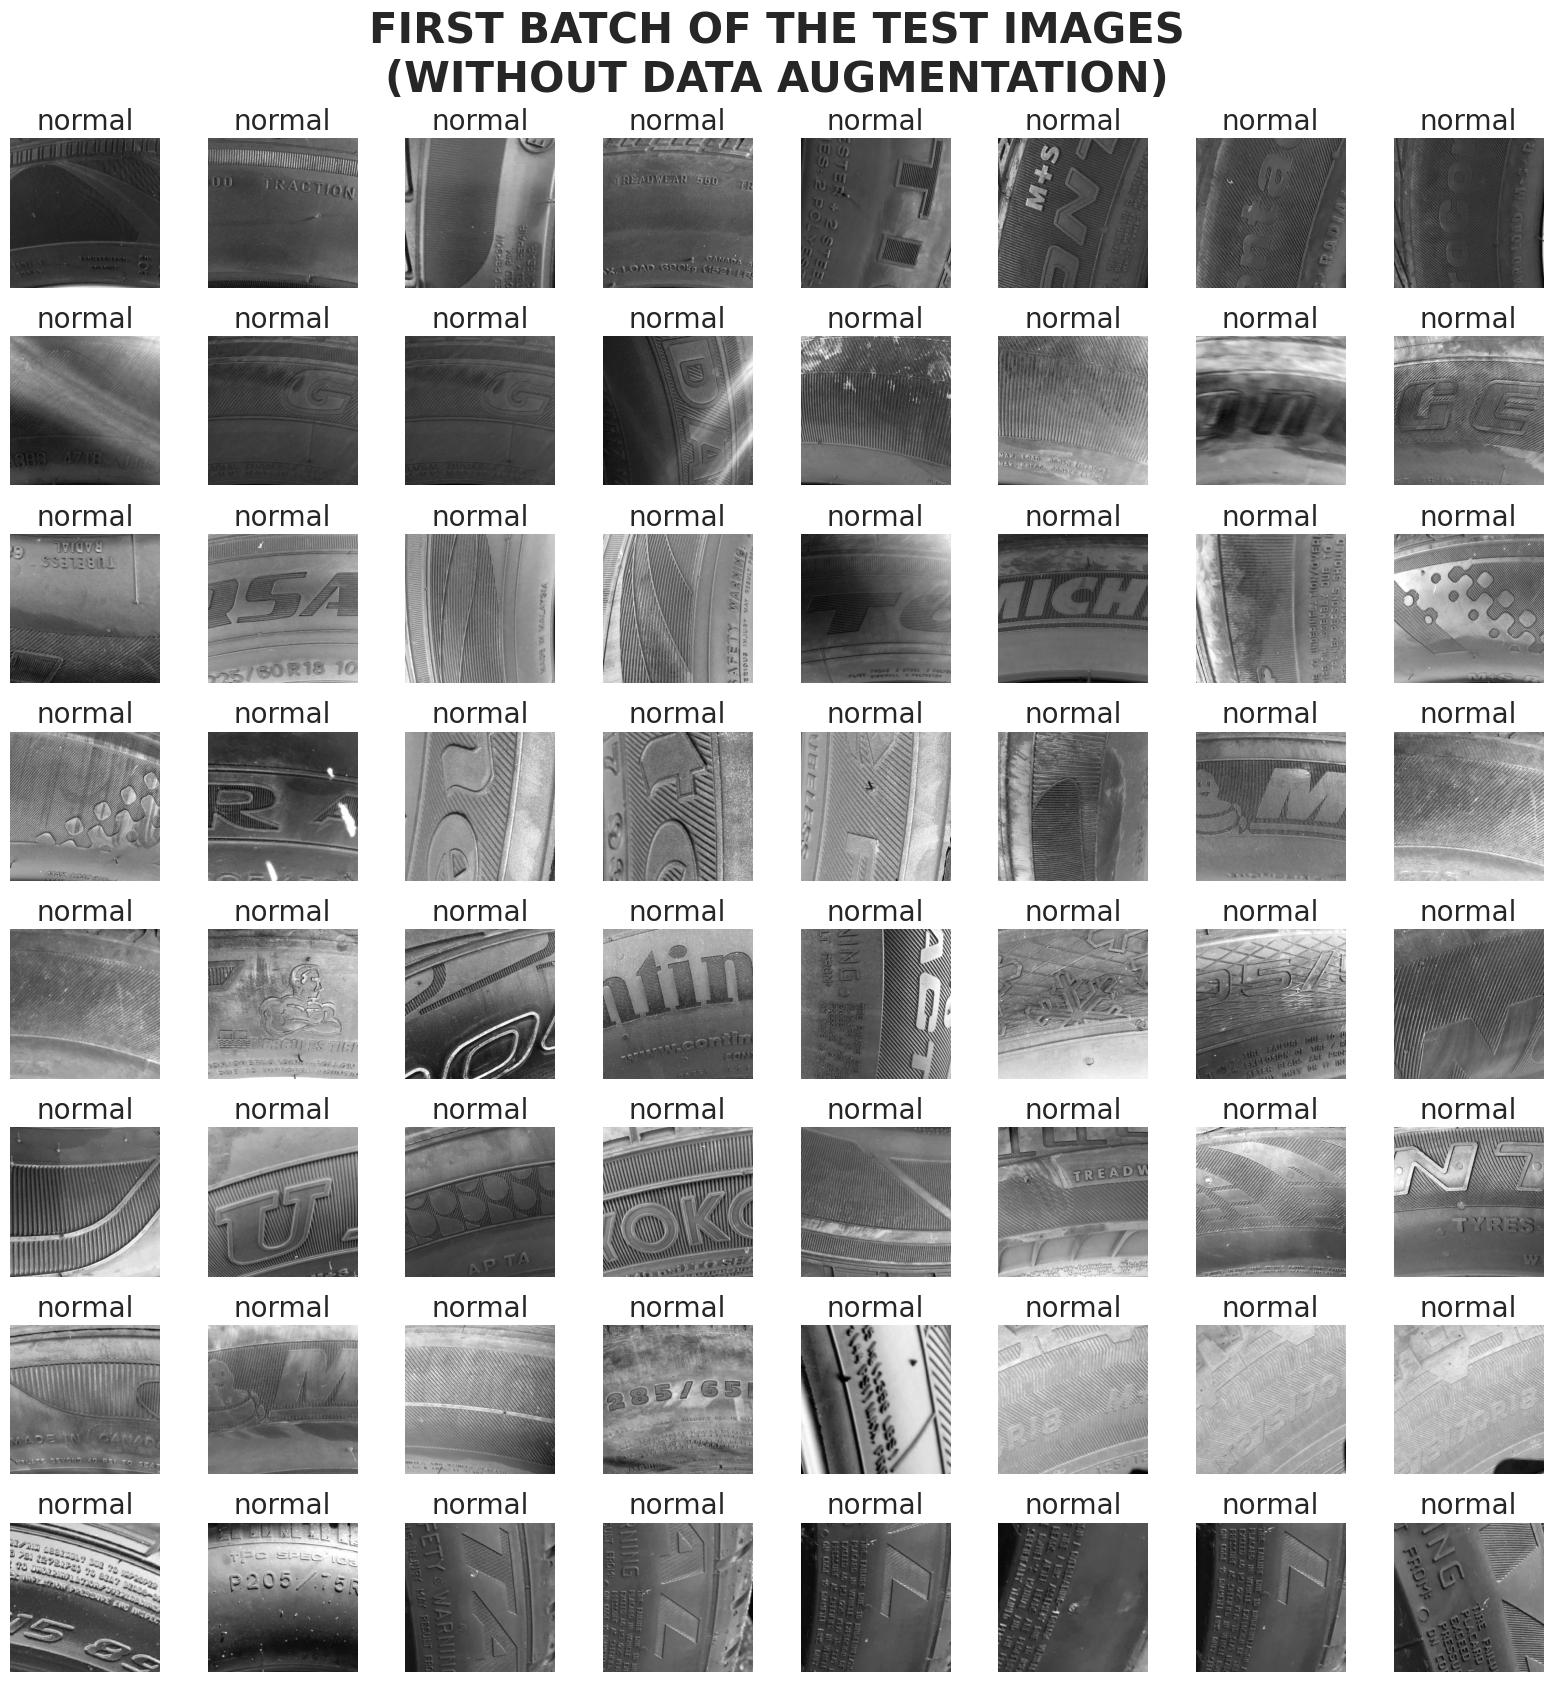

In [ ]:
test_images = visualizeImageBatch(test_dataset,
                                  "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")

# Modeling

In [ ]:
model_cnn = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 128,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),

        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),

        # Second convolutional layer
        Conv2D(filters = 64,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),

        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),

        # Third convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),

        # Third pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),

        # Forth convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),

        # Forth pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),

        # Flattening
        Flatten(),

        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),

        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),

        Dense(1, activation = "sigmoid")
    ]
)

model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 189, 189, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 94, 94, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 46, 46, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 11, 11, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 2, 2, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,657 (424.44 KB)

 Trainable params: 108,657 (424.44 KB)

 Non-trainable params: 0 (0.00 B)

# Model Compile

In [ ]:
model_cnn.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Model Callback

In [ ]:
checkpoint = ModelCheckpoint('model/cnn_tire_texture_model.keras',
                             verbose = 1,
                             save_best_only = True,
                             monitor='val_loss',
                             mode='min')

model_cnn.fit(train_dataset,
                    validation_data = validation_dataset,
                    batch_size = 16,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.5353 - loss: 0.6942
Epoch 1: val_loss improved from inf to 0.69076, saving model to model/cnn_tire_texture_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5351 - loss: 0.6942 - val_accuracy: 0.5357 - val_loss: 0.6908
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5285 - loss: 0.6919
Epoch 2: val_loss improved from 0.69076 to 0.69028, saving model to model/cnn_tire_texture_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 62s 918ms/step - accuracy: 0.5291 - loss: 0.6919 - val_accuracy: 0.5357 - val_loss: 0.6903
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5337 - loss: 0.6901
Epoch 3: val_loss did not improve from 0.69028
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5338 - loss: 0.6901 - val_accuracy: 0.5357 - val_loss: 0.6924
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.4892 - loss: 0.6950
Epoch 4: val_loss did not improve from 0.69028
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step 

# Model Flitting

In [ ]:
model_cnn.fit(
    train_dataset,
    validation_data = validation_dataset,
    batch_size = 64,
    epochs = 20,
    callbacks = [checkpoint],
    verbose = 1
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6480 - loss: 0.6230
Epoch 1: val_loss did not improve from 0.69028
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6486 - loss: 0.6233 - val_accuracy: 0.5500 - val_loss: 0.7044
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6388 - loss: 0.6347
Epoch 2: val_loss did not improve from 0.69028
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6422 - loss: 0.6332 - val_accuracy: 0.5214 - val_loss: 0.7589
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6987 - loss: 0.5971
Epoch 3: val_loss did not improve from 0.69028
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6958 - loss: 0.5998 - val_accuracy: 0.5571 - val_loss: 0.7663
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5873 - loss: 0.6895
Epoch 4: val_loss did not improve from 0.69028
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5883 - loss: 0.6877 - val_accuracy: 0.4500 - val_loss: 0.7382
Epoch 5/20
9/9 ━━━━━━━━━

# Training Evaluation Adam

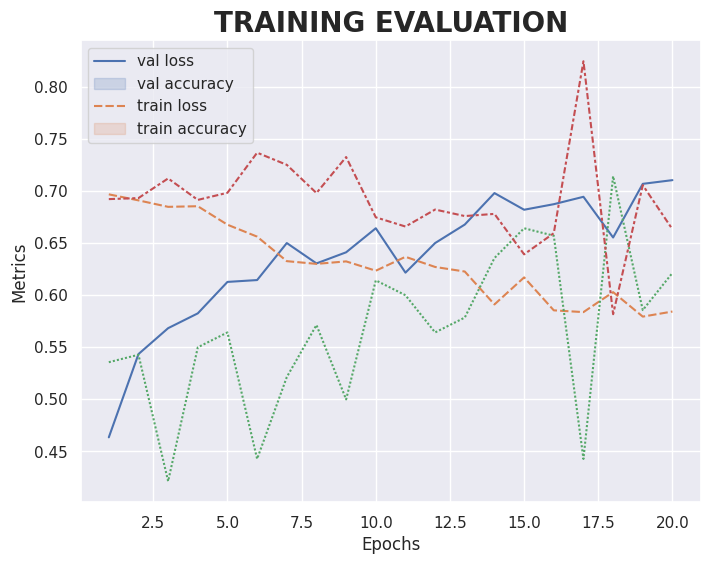

In [ ]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model_cnn.history.history,
                                 index = range(1, 1+len(model_cnn.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [ ]:
y_pred_prob = model_cnn.predict(test_dataset)

THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

cm = pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["Normal", "Cracked"]],
    columns = [["Predicted", "Predicted"], ["Normal", "Cracked"]],
)

print(cm)

print(classification_report(y_true_class, y_pred_class, digits = 4))


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 944ms/step
               Predicted        
                  Normal Cracked
Actual Normal         80      35
       Cracked        61     149
              precision    recall  f1-score   support

           0     0.5674    0.6957    0.6250       115
           1     0.8098    0.7095    0.7563       210

    accuracy                         0.7046       325
   macro avg     0.6886    0.7026    0.6907       325
weighted avg     0.7240    0.7046    0.7099       325



# Training Evaluation SGD

In [ ]:
 model_cnn.compile(optimizer = 'sgd',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

checkpoint = ModelCheckpoint('model/cnn_tire_texture_sgd_model.',
                             verbose = 1,
                             save_best_only = True,
                             monitor='val_loss',
                             mode='min')

In [ ]:
model_cnn.fit(
    train_dataset,
    validation_data = validation_dataset,
    batch_size = 64,
    epochs = 20,
    callbacks = [checkpoint],
    verbose = 1
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6837 - loss: 0.6011
Epoch 1: val_loss improved from inf to 1.03775, saving model to model/cnn_tire_texture_sgd_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 953ms/step - accuracy: 0.6839 - loss: 0.6002 - val_accuracy: 0.4643 - val_loss: 1.0378
Epoch 2/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6109 - loss: 0.6867
Epoch 2: val_loss improved from 1.03775 to 0.71206, saving model to model/cnn_tire_texture_sgd_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 757ms/step - accuracy: 0.6158 - loss: 0.6800 - val_accuracy: 0.5429 - val_loss: 0.7121
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7220 - loss: 0.5778
Epoch 3: val_loss improved from 0.71206 to 0.66499, saving model to model/cnn_tire_texture_sgd_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7215 - loss: 0.5784 - val_accuracy: 0.5786 - val_loss: 0.6650
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.6742 - l

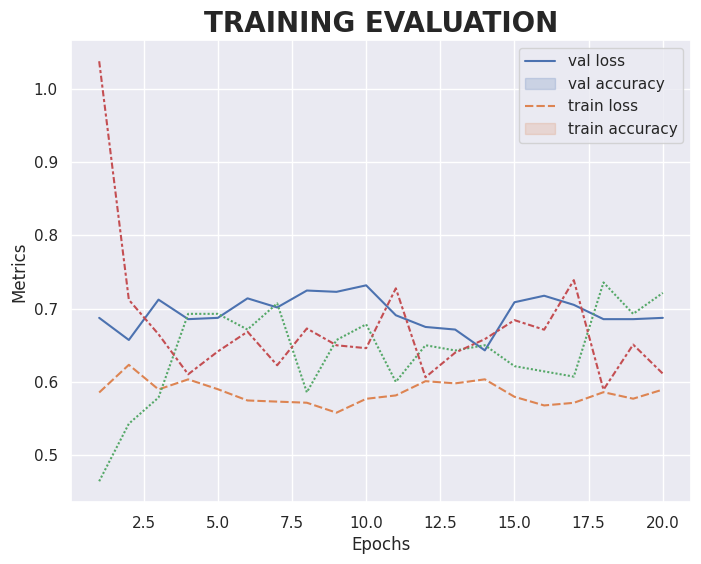

In [ ]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model_cnn.history.history,
                                 index = range(1, 1+len(model_cnn.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [ ]:
y_pred_prob = model_cnn.predict(test_dataset)

THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

cm = pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["Normal", "Cracked"]],
    columns = [["Predicted", "Predicted"], ["Normal", "Cracked"]],
)
print(cm)

print(classification_report(y_true_class, y_pred_class, digits = 4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
               Predicted        
                  Normal Cracked
Actual Normal         99      16
       Cracked       137      73
              precision    recall  f1-score   support

           0     0.4195    0.8609    0.5641       115
           1     0.8202    0.3476    0.4883       210

    accuracy                         0.5292       325
   macro avg     0.6199    0.6042    0.5262       325
weighted avg     0.6784    0.5292    0.5151       325



# Conclution
Dari beberapa percobaan, didapatkan arsitektur seperti yang digunaak saat ini dengan penggunaan adam optimizer, dengan tingkat akurasi 64.62% yang lebih tinggi dibandingkan SGD hanya 53.23% Namun hal ini masih belum cukup dikatakan good fit karena tingkat akurasi masih cukup jelek.

In [ ]:
from tensorflow.keras.models import load_model

# Save your model
model_cnn.save('cnn_model.h5')
